# Public transport stops with regular daytime weekday service


This notebook describes the example for a process to analyze bus stops points with regular daytime weekday service in a city, using v1.0.0 of the software or earlier (https://github.com/global-healthy-liveable-cities/global-indicators/releases/tag/v1.0.0).  The processes described here are not currently supported but retained as a historical reference that may later be updated.

### Method: Stop headway analysis using average frequencies of departure during day time


### Process:
1. Set up study region GTFS analysis parameters (gtfs_config.py)  
2. Load GTFS data into an UrbanAccess transit data frame
    - stops will be loaded limited within study region buffered bounding box
3. Stop headway analysis using average departure time during usual weekday (Monday-Friday) daytime (7am-7pm) for all feeds (one city can have more than one feeds) and modes of transport
4. Summarize headway by modes of transport for total, <=30min, and <=20min 


A handy guide to the format of GTFS fields is [here](https://developers.google.com/transit/gtfs/reference/#tripstxt)   
Previous working branch:

https://github.com/shiqin-liu/global-indicators/blob/phoenix/process/07_create_frequent_public_transport.ipynb  
https://github.com/shiqin-liu/global-indicators/blob/GTFS_analysis/process/GTFS_freq_stop/setup_GTFS_frequent_stops_headway.ipynb


In [2]:
import pandas as pd
import geopandas as gpd
import os
import time
import networkx as nx
import osmnx as ox
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import shape, Point, LineString, Polygon

import calendar
import datetime
from datetime import timedelta


import urbanaccess as ua
import ua_load
import gtfs_config

# module with functions to calculate the average headway during the timeframe over departure
import gtfs_headway_analysis as gha

%matplotlib inline


In [22]:
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)


In [6]:
# set up study region GTFS config
# these gtfs parameters are defined in gtfs_config.py file
GTFS = gtfs_config.GTFS
cities = GTFS.keys()         

cities

dict_keys(['maiduguri', 'hong_kong', 'chennai', 'bangkok', 'hanoi', 'graz', 'ghent', 'bern', 'olomouc', 'odense', 'vic', 'belfast', 'adelaide', 'melbourne', 'sydney', 'phoenix', 'mexico_city', 'baltimore', 'sao_paulo', 'auckland', 'seattle', 'cologne', 'barcelona', 'valencia', 'lisbon'])

In [7]:
dow=['monday','tuesday','wednesday','thursday','friday']
analysis_period   = gtfs_config.analysis_period
headway_intervals = gtfs_config.headway_intervals
print(analysis_period, headway_intervals)

In [25]:
# set up a study region config to run in this notebook
city = 'adelaide'
city_proper = f"{city.title().replace('_',' ')}"

# examine the config file
city_config = GTFS[city]
city_config

[{'gtfs_filename': 'gtfs_input_data/gtfs_au_adelaide/gtfs_au_sa_adelaidemetro_20191004',
  'gtfs_provider': 'AdelaideMetro',
  'gtfs_year': '2019',
  'start_date_mmdd': '20191008',
  'end_date_mmdd': '20191205',
  'bbox': (138.46098938116273,
   -35.15966609024628,
   138.7483172991119,
   -34.71454282915053),
  'crs': 'epsg:7845',
  'validation': False,
  'modes': {'Tram': {'route_types': [0], 'agency_id': None},
   'Metro': {'route_types': [1], 'agency_id': None},
   'Rail': {'route_types': [2], 'agency_id': None},
   'Bus': {'route_types': [3], 'agency_id': None},
   'Ferry': {'route_types': [4], 'agency_id': None},
   'Cable tram': {'route_types': [5], 'agency_id': None},
   'Aerial lift': {'route_types': [6], 'agency_id': None},
   'Funicular': {'route_types': [7], 'agency_id': None},
   'Trolleybus': {'route_types': [11], 'agency_id': None},
   'Monorail': {'route_types': [12], 'agency_id': None}}}]

In [26]:
# set up configuration parameters
# using the loop here since cities could have more than one feeds
for feed in city_config:
    gtfsfeed_name = feed['gtfs_filename']
    gtfsfeed_path = os.path.abspath(os.path.join('../../data/GTFS',gtfsfeed_name))
    print(f'\n{gtfsfeed_path}')
    authority = feed['gtfs_provider'] # note: this is not necessarily transit agency; could be data source like data.gov.hk, combining multiple agencies
    start_date = feed['start_date_mmdd']
    end_date = feed['end_date_mmdd']
    bbox = feed['bbox']
    crs = feed['crs']
    validation = feed['validation']
    if validation == False:
        ## UrbanAccess validation noted to incorrectly parse some feeds; so we manually restrict stop times
        ## to stops within bounding box.  So we don't rely on UrbanAccess validation and manually restrict
        ## to provided bounding box
        # manually load stop_times as df
        if os.path.exists(f'{gtfsfeed_path}/stop_times_original.txt'):
            # this algorithm may have previously been run, so load original just in case
            df = pd.read_csv(f'{gtfsfeed_path}/stop_times_original.txt')
        else:
            df = pd.read_csv(f'{gtfsfeed_path}/stop_times.txt')
            os.rename(f'{gtfsfeed_path}/stop_times.txt',f'{gtfsfeed_path}/stop_times_original.txt')
        # restrct df to bbox stops
        df_stops = pd.read_csv(f'{gtfsfeed_path}/stops.txt')
        df_stops = df_stops.query(f'stop_lat >= {bbox[1]} and stop_lat <= {bbox[3]} and stop_lon>={bbox[0]} and stop_lon<={bbox[2]}')
        df = df[df.stop_id.astype(str).isin(df_stops.astype(str).stop_id)]
        df.to_csv(f'{gtfsfeed_path}/stop_times.txt',index=False)
    else:
        if os.path.exists(f'{gtfsfeed_path}/stop_times_original.txt'):
            # this algorithm may have previously been run, so replace original just in case
            os.rename(f'{gtfsfeed_path}/stop_times_original.txt',f'{gtfsfeed_path}/stop_times.txt')


/home/jovyan/work/Documents/GitHub/global-indicators/process/data/GTFS/gtfs_input_data/gtfs_au_adelaide/gtfs_au_sa_adelaidemetro_20191004


# Load GTFS data into an UrbanAccess transit data frame

### Using UrbanAccess as source for:
- The settings object
- The feeds object and searching for GTFS feeds
- Loading GTFS data into a UrbanAccess transit data object


In [27]:
# revise based on origional function from UrbanAccess, take out the add agency and route type features
# we may want to limit the stops within the study region bounding box for efficiency, as some feeds are regional system
loaded_feeds = ua_load.gtfsfeed_to_df(gtfsfeed_path=gtfsfeed_path, validation=validation, bbox=bbox, remove_stops_outsidebbox=True)

--------------------------------
GTFS text file header whitespace check completed. Took 4.33 seconds
--------------------------------
Processing GTFS feed: gtfs_au_sa_adelaidemetro_20191004
Successfully converted ['departure_time'] to seconds past midnight and appended new columns to stop_times. Took 3.32 seconds
1 GTFS feed file(s) successfully read as dataframes:
     gtfs_au_sa_adelaidemetro_20191004
     Took 9.49 seconds


### The transit data object

The output is a global `urbanaccess_gtfs_df` object that can be accessed with the specified variable `loaded_feeds`. This object holds all the individual GTFS feed files aggregated together with each GTFS feed file type in separate Pandas DataFrames to represent all the loaded transit feeds in a metropolitan area. 

Quickly view the transit stop locations

<AxesSubplot:xlabel='stop_lon', ylabel='stop_lat'>

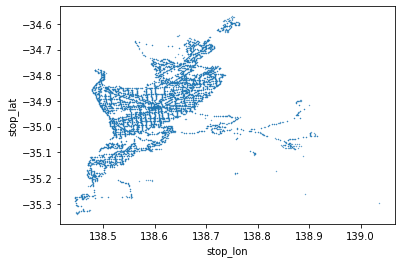

In [28]:
loaded_feeds.stops.plot(kind='scatter', x='stop_lon', y='stop_lat', s=0.1)


# Stop headway analysis using average departure time during weekday daytime

- identify feeds start and end dates and the stop operates during normal weekday daytime
- group by service date, stop id and direction id, then get counts of departure of each stop of each direction per day
- calculate the average headway over dates
- take lowest headway for each stop out of each direction  

(If a frequencies file exists for the feed, that indicates that the stop has pre-defined heaway data, then use that instead of stops_headway. So, we need to restrict frequencies to those with valid trips)  

(approach taken by Carl Higgs (20200106) following [tidytransit](http://tidytransit.r-transit.org/articles/servicepatterns.html))

In [30]:
# load frequencies if exists
for root, dirs, files in os.walk(gtfsfeed_path):
    # naive assumption that only one frequencies.txt exists in feed path...
    for file in files:
        if file == 'frequencies.txt':
            frequencies_df = pd.read_csv(os.path.join(root, file))
            frequencies_df.set_index('trip_id',inplace=True)
            
if 'frequencies_df' not in locals():
    frequencies_df = ''

In [31]:
print(f'\n{city_proper} analysis:\n  - {gtfsfeed_path}\n  - {start_date} to {end_date}\n - {analysis_period}\n\n')


Adelaide analysis:
  - /home/jovyan/work/Documents/GitHub/global-indicators/process/data/GTFS/gtfs_input_data/gtfs_au_adelaide/gtfs_au_sa_adelaidemetro_20191004
  - 20191008 to 20191205
 - ['07:00:00', '19:00:00']




In [33]:
feed['modes'].keys()

dict_keys(['Tram', 'Metro', 'Rail', 'Bus', 'Ferry', 'Cable tram', 'Aerial lift', 'Funicular', 'Trolleybus', 'Monorail'])

In [36]:
# loop through each mode of transport with the feed
stop_frequent = pd.DataFrame()
for mode in feed['modes'].keys():
    #print(mode)
    startTime = time.time()
    start_hour = analysis_period[0]
    end_hour = analysis_period[1]

    route_types = feed['modes'][f'{mode}']['route_types']
    agency_ids = feed['modes'][f'{mode}']['agency_id']

    # Summarize dataframe of stops with average headway 
    # based on the number of daily departures within a given timeframe
    stops_headway = gha.get_hlc_stop_frequency(loaded_feeds, start_hour, end_hour, start_date,
                       end_date, route_types, agency_ids,
                       dow=dow,
                       frequencies = frequencies_df)

    stop_count = len(stops_headway)
    duration = time.time() - startTime
    if stop_count > 0:
        stop_frequent_final = pd.merge(stops_headway, loaded_feeds.stops, how='left', on='stop_id')
        stop_frequent_final['authority'] = authority
        stop_frequent_final['mode'] = mode
        stop_frequent_final['feed'] = gtfsfeed_name
        stop_frequent =  stop_frequent.append(stop_frequent_final)

    print(f'     {mode:13s} {stop_count:9.0f} stops identified ({duration:,.2f} seconds)')


     Tram                 62 stops identified (0.28 seconds)
     Metro                 0 stops identified (0.12 seconds)
     Rail                149 stops identified (0.31 seconds)
     Bus                6344 stops identified (6.84 seconds)
     Ferry                 0 stops identified (0.09 seconds)
     Cable tram            0 stops identified (0.09 seconds)
     Aerial lift           0 stops identified (0.11 seconds)
     Funicular             0 stops identified (0.09 seconds)
     Trolleybus            0 stops identified (0.09 seconds)
     Monorail              0 stops identified (0.10 seconds)


In [37]:
# get spatial features for freqent stops
# add stop id geometry
stop_frequent['geometry'] = stop_frequent.apply(
    lambda row: Point(row['stop_lon'], row['stop_lat']), axis=1)
stop_frequent_gdf = gpd.GeoDataFrame(stop_frequent)

# define projection, same as study region projection
default_crs = 'epsg:4326'
stop_frequent_gdf.crs = {'init' :'{}'.format(default_crs)}
stop_frequent_gdf = ox.projection.project_gdf(stop_frequent_gdf, to_crs=crs, to_latlong=False)


In [58]:
len(stop_frequent_gdf)

6555

In [39]:
# show frequent stop stats
tot_df = stop_frequent_gdf.groupby('mode')[['stop_id']].count().rename(columns = {'stop_id':'tot_stops'})
headway30_df = stop_frequent_gdf[stop_frequent_gdf['headway']<=30].groupby('mode')[['stop_id']].count().rename(columns = {'stop_id':'headway<=30'})
headway20_df = stop_frequent_gdf[stop_frequent_gdf['headway']<=20].groupby('mode')[['stop_id']].count().rename(columns = {'stop_id':'headway<=20'})

mode_freq_comparison = pd.concat([tot_df, headway30_df, headway20_df], axis=1)
mode_freq_comparison.loc["total"] = mode_freq_comparison.sum()

mode_freq_comparison['pct_headway<=30'] = (mode_freq_comparison['headway<=30']*100 / mode_freq_comparison['tot_stops']).round(2)
mode_freq_comparison['pct_headway<=20'] = (mode_freq_comparison['headway<=20']*100 / mode_freq_comparison['tot_stops']).round(2)
print(f'\n{city.title()} summary (all feeds):\n{mode_freq_comparison}\n\n')



Adelaide summary (all feeds):
       tot_stops  headway<=30  headway<=20  pct_headway<=30  pct_headway<=20
mode                                                                        
Bus         6344         4815         2577            75.90            40.62
Rail         149          147           65            98.66            43.62
Tram          62           62           62           100.00           100.00
total       6555         5024         2704            76.64            41.25




In [5]:

gpkgPath_output = os.path.join(dirname, f'gtfs_frequent_transit_headway_{today}_python.gpkg')
gpkgPath_output

'/home/jovyan/work/Documents/GitHub/global-indicators/process/pre_process/GTFS_stops_headway/gtfs_frequent_transit_headway_2021-06-08_python.gpkg'

In [59]:
# save to output file
# save the frequent stop by study region and modes to a new layer in geopackage
#dirname = os.path.abspath('')
#today = time.strftime('%Y-%m-%d')
#gpkgPath_output = os.path.join(dirname, f'gtfs_frequent_transit_headway_{today}_python.gpkg')
#stop_frequent_gdf.to_file(gpkgPath_output, layer=f'{city}_stops_headway_{start_date}_{end_date}', driver='GPKG')

# Plot all PT stop and freqent PT bus stops

In [42]:
# get the study region boundary gdf
city = 'adelaide'
region = 'au'
geopackagePath = '../../data/input/{city}_{region}_2020_1600m_buffer.gpkg'.format(
        city=city, region=region)

# load shapefile and project to latlong for plotting with PT points
shape = gpd.GeoDataFrame.from_file(geopackagePath, 
              layer='urban_study_region')

/opt/conda/lib/python3.7/site-packages/geopandas/geodataframe.py:294: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for f in features_lst:


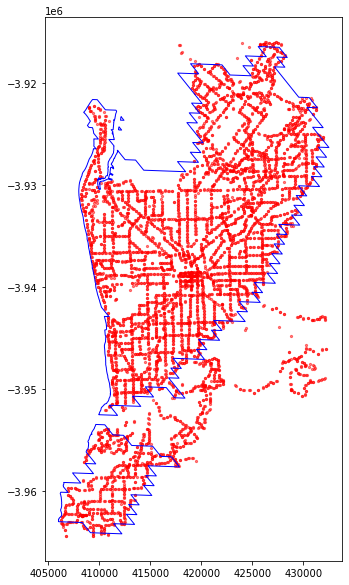

In [57]:
# plot the stops
fig, ax = plt.subplots(figsize=(10, 10))
ax = stop_frequent_gdf.plot(ax=ax, color='red', marker='o', markersize=5, alpha=0.5)
ax = shape.plot(ax=ax, color='none', edgecolor='blue')

#ax.set_axis_off()

plt.show()